In [1]:
# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import pandas as pd
import japanize_matplotlib

# 学習結果

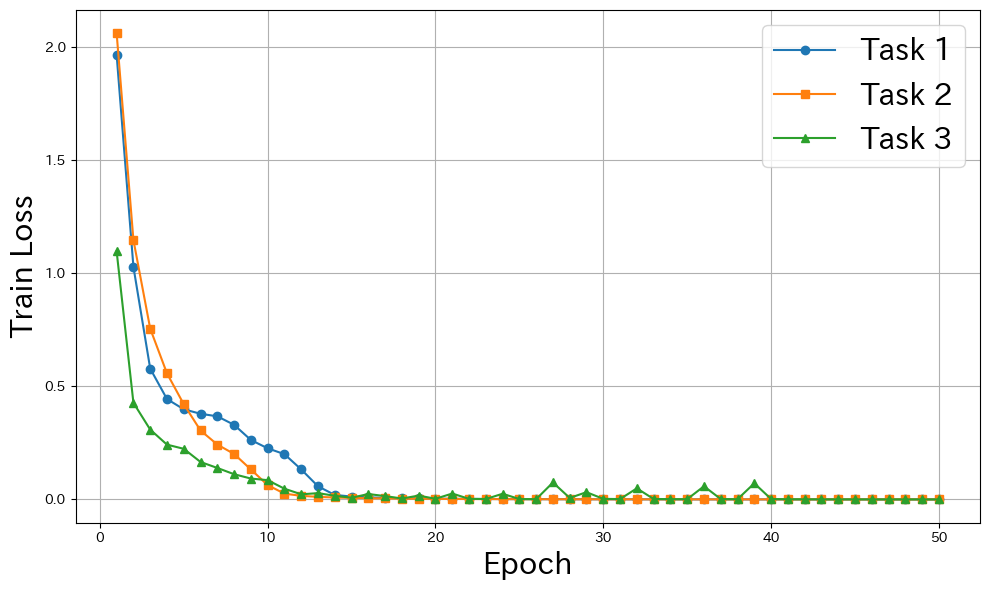

In [6]:

# ファイルの読み込み
task1 = pd.read_csv('model/06-1/06-1_losses.csv')
task2 = pd.read_csv('model/06-2/06-2_losses.csv')
task3 = pd.read_csv('model/06-3/06-3_losses.csv')

fontsize = 22

# train_loss のプロット
plt.figure(figsize=(10, 6))

# 各タスクのプロット
plt.plot(task1['epoch'], task1['train_loss'], label='Task 1', marker='o')
plt.plot(task2['epoch'], task2['train_loss'], label='Task 2', marker='s')
plt.plot(task3['epoch'], task3['train_loss'], label='Task 3', marker='^')

# グラフの装飾
# plt.title('Train Loss Over Epochs for Task 1, 2, and 3')
plt.xlabel('Epoch', fontsize=fontsize)
plt.ylabel('Train Loss', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)
plt.tight_layout()

# グラフの表示
plt.show()


# 分析



## 初期設定

### データセット定義

In [16]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [17]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_file("data/eq05-1.txt")
vocab_src1 = vocab_tgt1 = build_vocab(src_data + tgt_data)

src_data, tgt_data = read_file("data/eq05-2.txt")
vocab_src2 = vocab_tgt2 = build_vocab(src_data + tgt_data)

src_data, tgt_data = read_file("data/eq05-3.txt")
vocab_src3 = vocab_tgt3 = build_vocab(src_data + tgt_data)


### モデル定義

In [18]:
model_path_1 = "./model/06-1/06-1translation_transfomer.pth"
model_path_2 = "./model/06-2/06-2translation_transfomer.pth"
model_path_3 = "./model/06-3/06-3translation_transfomer.pth"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [24]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, PAD_IDX):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        #Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        return tgt

class TransformerEncoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerScratch, self).__init__()
        # Self-attention for the encoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        memory, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        memory = src + self.dropout1(memory)
        memory = self.norm1(memory)
        
        return memory


class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        vocab_src,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size, PAD_IDX=vocab_src['<pad>'])
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        self.encoder_layer = TransformerEncoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )

        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        memory = self.encoder_layer(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs/math.sqrt(self.token_embedding.embedding_size), self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)
    

def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [25]:


#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.pca = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attn_decoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.decoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.decoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.decoder_layer.self_attn.out_proj.weight.data.T) + self.decoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights

    def self_attn_encoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.encoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.encoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.encoder_layer.self_attn.out_proj.weight.data.T) + self.encoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attn(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.decoder_layer.cross_attn.out_proj.weight.data.T) + self.decoder_layer.cross_attn.out_proj.bias.data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights

    def predict_next_token(self, src, tgt, embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding(tgt))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)

        memory, _, _ = self.self_attn_encoder(memory, embedding_size)
        memory = self.encoder_layer.norm1(memory)
        # memory = self.encoder_layer.norm2(F.relu(self.encoder_layer.linear1(memory)) + memory)

        tgt, _, self_attn_weights = self.self_attn_decoder(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)
        tgt, _, multi_attn_weights = self.cross_attn(tgt, memory, embedding_size)
        tgt = self.decoder_layer.norm2(tgt)
        # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights
    


In [27]:
# モデルの初期化
loaded_model1 = Seq2SeqForSavedModel(
    num_encoder_layers=1,
    num_decoder_layers=1,
    embedding_size=4,
    vocab_src=vocab_src1,
    vocab_size=len(vocab_src1),
    dim_feedforward=4,
    dropout=0, nhead=1
).to(device)
loaded_model1.load_state_dict(torch.load(model_path_1))
loaded_model1.eval()

# モデルの初期化
loaded_model2 = Seq2SeqForSavedModel(
    num_encoder_layers=1,
    num_decoder_layers=1,
    embedding_size=4,
    vocab_src=vocab_src1,
    vocab_size=len(vocab_src1),
    dim_feedforward=4,
    dropout=0, nhead=1
).to(device)
loaded_model2.load_state_dict(torch.load(model_path_1))
loaded_model2.eval()

# モデルの初期化
loaded_model2 = Seq2SeqForSavedModel(
    num_encoder_layers=1,
    num_decoder_layers=1,
    embedding_size=4,
    vocab_src=vocab_src1,
    vocab_size=len(vocab_src1),
    dim_feedforward=4,
    dropout=0, nhead=1
).to(device)
loaded_model2.load_state_dict(torch.load(model_path_1))
loaded_model2.eval()



Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)



## Attentionの図示

NameError: name 'model_dir_path' is not defined